# Infomación de entrega

**Nombre estudiante:**


## 0) Setup

In [1]:
!pip install keras --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [2]:
# Importar librerías

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout


## 1) Carga del dataset

El dataset Cora consiste en 2.708 papers científicos clasificados en una de 7 posibles clases. La red de citas/referencias consiste en 5.429 arcos. Cada paper tiene un vector de palabras binario de tamaño 1.433, indicando la presencia o ausencia de la palabra correspondiente.

El dataset tiene dos archivos separados:

1. El archivo `cora.cites` incluye las citas/referencias en dos columnas:
`cited_paper_id` (*target*) y `citing_paper_id` (*source*).
2. El archivo `cora.content` incluye una descripción del contenido del paper en 1.435 columnas: `paper_id`, `subject`, y 1.433 *features* binarias.


In [4]:
# Descarga de datos
!mkdir -p ./data/cora
!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz -O ./data/cora.tgz
!tar -xvzf ./data/cora.tgz -C ./data/cora/ --strip-components=1

--2024-10-30 21:32:47--  https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.47.74
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.47.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168052 (164K) [application/x-gzip]
Saving to: ‘./data/cora.tgz’

./data/cora.tgz     100%[===================>] 164.11K   570KB/s    in 0.3s    

2024-10-30 21:32:48 (570 KB/s) - ‘./data/cora.tgz’ saved [168052/168052]

cora/README
cora/cora.cites
cora/cora.content


In [5]:
# Cargar datos utilizando pandas

In [6]:
citations = pd.read_csv(
    Path("data", "cora", "cora.cites"),
    names=["target", "source"],
    sep="\t",
    header=None,
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [7]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [8]:
citations.sample(frac=1).head()

,target,source
3590,73162,1134348
11,35,1117476
1912,13193,17208
3903,95642,990075
3339,56115,69284


In [9]:
# Cargar el archivo `cora.content` en un DataFrame
content = pd.read_csv(
    Path("data", "cora", "cora.content"),  # Especifica la ruta del archivo
    sep="\t",  # Especifica que las columnas están separadas por tabulaciones
    header=None  # Indica que el archivo no tiene encabezado en la primera fila
)

# Renombrar las columnas para mejorar la legibilidad
content.columns = ["paper_id"] + [f"term_{i}" for i in range(1433)] + ["subject"]

# Mostrar las primeras filas de la tabla
content.head()


,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


El código carga y prepara el archivo cora.content, asignándole nombres a las columnas y mostrando la dimensión del conjunto de datos.

In [10]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(Path("data", "cora", "cora.content"), sep="\t", header=None, names=column_names)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [11]:
papers.sample(5).T

,400,206,100,289,1643
paper_id,1107567,133563,134199,3828,6378
term_0,0,0,0,0,0
term_1,0,0,0,0,0
term_2,0,0,0,0,1
term_3,0,0,0,0,0
...,...,...,...,...,...
term_1429,0,0,0,0,0
term_1430,0,0,0,0,0
term_1431,0,0,0,0,0
term_1432,0,0,0,0,0


In [12]:
print(papers.subject.value_counts())

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64


In [13]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

#### Preguntas

Una vez cargado el dataset debes responder las siguientes preguntas:

1. ¿Qué tipos de nodos y aristas tiene el grafo?

2. ¿Cuántas features tiene cada nodo?

3. ¿Cuántos nodos y aristas forman el grafo?


#### Respuestas

1. ...
2. ...
3. ...
4. ...
5. ...

## 2) Análisis del grafo

Un paso importante antes de aplicar *machine learning* sobre un conjunto de datos es el análisis de datos. Para esto, aprovecharemos de usar la librería NetworkX para obtener información sobre nuestro grafo.

In [14]:
# Crear grafo en NetworkX con datos cargados

In [15]:
%%time
cora_graph = nx.from_pandas_edgelist(citations.sample(n=2000))  # Nuevo grafo
pos = nx.spring_layout(cora_graph, seed=0)  # Posición de los nodos

CPU times: user 24.3 s, sys: 385 ms, total: 24.7 s
Wall time: 43.8 s


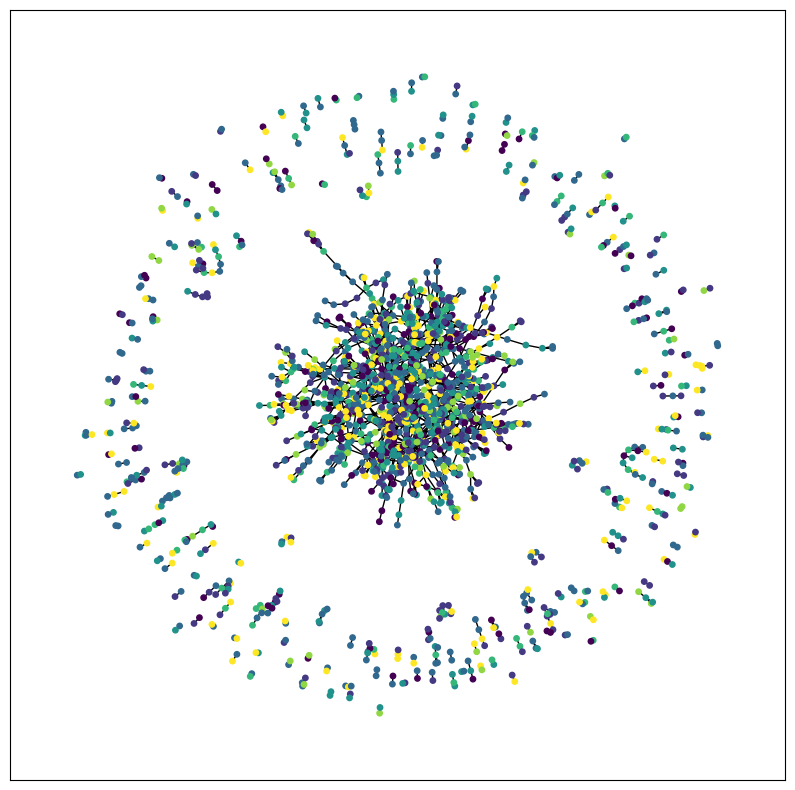

In [16]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_networkx(cora_graph, pos=pos, node_size=15, node_color=subjects, with_labels=False)  # Gráfico

#### Preguntas

Una vez instanciado el grafo, debes responder las siguientes preguntas utilizando NetworkX:

1. ¿Cuál es el grado promedio de los nodos en el grafo?

2. ¿Cuál es el diámetro del grafo?

3. ¿Cuál es la densidad de la matriz de adyacencia del grafo?

4. Realizar un gráfico mostrando los nodos (un subconjunto) y sus arcos respectivos


## 3) Split del dataset


Otro paso importante es realizar la partición de datos etiquetados en conjuntos de entrenamiento y test. Para esto, para cada etiqueta, se debe tomar la mitad de los papers para cada conjunto (50%).

In [17]:
# Partición de datos en train y test como numpy array

In [18]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Seleccionamos cerca del 50% del dataset para entrenamiento
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1370, 1435)
Test data shape: (1338, 1435)


#### Preguntas

1. ¿En qué formato se encuentran almacenados los splits?
2. ¿Qué podría ocurrir si no realizamos la partición sobre cada etiqueta sino que sobre todo el conjunto de datos directamente (es decir, no haceerlo de manera estratificada)?
3. ¿Estamos en presencia de un contexto inductivo o transductivo?
4. Mencione un ejemplo de técnica de *data augmentation* que podría aplicar en este conjunto de datos.
5. Si tuviéramos los *timestamps* de cada paper (es decir, cuando se publicó cada paper), ¿podríamos usar esta información en este paso? Si es así, ¿cómo podríamos utilizar el momento de publicación de cada paper para particionar los datos?

## 4) Creacion de la red

### GCN

En este paso, deberás crear una GCN. Para esto, deberás definir la clase `GraphConvLayer` que solo deberá recibir como parámetro la cantidad de capas ocultas a utilizar en el paso de cálculo de mensajes.

En esta implementación de la GCN, los pasos a implementar son:

$h_v^{(l)} = \text{ADD}(\text{MEAN}(\{W^{(l)} \times h_u^{(l-1)}, u\in N(v)\}), W^{(l)} \times h_v^{(l-1)})$

1. Cálculo del mensaje
2. Agregación de los mensajes de vecinos (usar promedio)
3. Actualizar *embedding* de cada nodo usando la suma de los mensajes agregados y la representación actual del nodo.

Por otra parte, para definir la GCN deberás definir la clase `GCNNodeClassifier`, que también recibirá como parámetro la cantidad de capas ocultas a utilizar.

Las capas del modelo `GCNNodeClassifier` que debes crear son:

1. Una sección de FFN que tenga `hidden_units` unidades ocultas
2. Una capa convolucional (`GraphConvLayer`) que reciba el parámetro `hidden_units`.
3. Una capa densa para clasificar las `num_classes` unidades.

Notar que cada capa densa de una FFN deberá utilizar *batch normalization*, *dropout* (0.3) y activación ReLU. Asegúrate que las capas internas sean parte del modelo.

In [19]:
# Hiperparámetros GCN (definir como CONSTANTES)

In [20]:
hidden_units = [32, 16]
learning_rate = 0.01
num_epochs = 300
batch_size = 256

In [21]:
# Funciones auxiliares (por ejemplo, para crear una FNN)

In [22]:
def run_experiment(model, x_train, y_train):
    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Creación de callback paara early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Entrenamiento del modelo
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [23]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [24]:
# Funciona con GCN y SAGE
def create_ffn1(units, name=None):
    fnn_layers = [
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(units, activation=tf.nn.gelu)
    ]
    return keras.Sequential(fnn_layers, name=name)

In [25]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Separamos las features de entrenamiento y test como numpy array
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Separamos las etiquetas de entrenamiento y test como numpy array
y_train = train_data["subject"]
y_test = test_data["subject"]

In [26]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features and edges
graph_info = (node_features, edges)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [27]:
# Clase GraphConvLayer

In [28]:
class GraphConvLayer(layers.Layer):
    def __init__(self, hidden_units: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ffn1_prepare = create_ffn1(hidden_units)
        self.update_fn = create_ffn1(hidden_units)

    def prepare(self, node_representations):
        # node_representations.shape = [num_edges, embedding_dim]
        # Cacular los mensajes (MSG) de los vecinos
        messages = self.ffn1_prepare(node_representations)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_representations):
        # node_indices.shape = [num_edges]
        # neighbour_messages.shape = [num_edges, representation_dim]
        # node_representations.shape = [num_nodes, representation_dim]
        # Aggregar (AGG) los mensajes de los vecinos calculando el promedio
        num_nodes = node_representations.shape[0]
        aggregated_message = tf.math.unsorted_segment_mean(
            neighbour_messages, node_indices, num_segments=num_nodes
        )
        return aggregated_message

    def update(self, node_representations, aggregated_messages):
        # node_representations.shape = [num_nodes, representation_dim]
        # aggregated_messages.shape = [num_nodes, representation_dim]
        # Actualizamos la representación de cada nodo con la nueva (CONCAT)
        h = tf.concat([node_representations, aggregated_messages], axis=1)

        # Aplicamos la función de procesamiento
        node_embeddings = self.update_fn(h)
        node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, node_representations, edges):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of two elements: node_representations and edges
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        # Recuperamos los nodos de inicio (node_indices) y de llegada (neighbour_indices) desde los arcos
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations.shape = [num_edges, representation_dim]
        neighbour_repesentations = tf.gather(node_representations, neighbour_indices)

        # GCN:
        # 1. Preparamos los mensajes de los vecinos
        neighbour_messages = self.prepare(neighbour_repesentations)
        # 2. Agregamos los mensajes de los vecinos
        aggregated_messages = self.aggregate(node_indices, neighbour_repesentations, node_representations)
        # 3. Actualizamos los embeddings de los nodos con los mensajes de los vecinos
        return self.update(node_representations, aggregated_messages)

In [29]:
# Clase GCNNodeClassifier

In [30]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        # Unpack graph_info to two elements: node_features and edges
        node_features, edges = graph_info
        self.node_features = node_features
        self.edges = edges

        # Preprocessing layer
        self.preprocess = create_ffn1(hidden_units, name="preprocess")
        # Two GraphConv layers
        self.conv1 = GraphConvLayer(hidden_units, name="graph_conv1")
        # self.sage1 = SageConvLayer(hidden_units, name="sage_conv1")
        # Dense layer for classification
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x = self.conv1(x, self.edges)
        # x = self.sage1(x, self.edges)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)

Crea una instancia de tu modelo que reciba la información del grafo, el número de clases, y `[8, 16]` como valor para `hidden_units`. Imprime las capas de tu instancia del modelo.

In [31]:
# Creación de modelo e impresión de parámetros

In [32]:
# Definir los parámetros de entrada
graph_info = (node_features, edges)  # Asegúrate de que esto esté definido correctamente
num_classes = 10  # Cambia esto según tu número de clases
hidden_units = 64  # Cambia esto según tus necesidades

# Instanciar el modelo GNN
gnn_model1 = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    name="gnn_model1"
)

# Crear una entrada dummy para construir el modelo
dummy_input = tf.constant([0])  # Asumiendo que la entrada es un índice entero de nodos
_ = gnn_model1(dummy_input)       # Ejecuta una pasada con el dummy_input

# Obtener el resumen del modelo
gnn_model1.summary()


Model: "gnn_model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ (2708, 64)                  │          97,508 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphConvLayer)         │ ?                           │          13,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ (1, 10)                     │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,342 (434.93 KB)

 Trainable params: 108,092 (422.23 KB)

 Non-trainable params: 3,250 (12.70 KB)

In [33]:
#tf.keras.utils.plot_model(gnn_model1, show_shapes=True, show_layer_names=True, expand_nested=True)

In [34]:
# x_train = train_data.paper_id.to_numpy()
# history = run_experiment(gnn_model1, x_train, y_train)

In [35]:
# display_learning_curves(history)

In [36]:
# x_test = test_data.paper_id.to_numpy()
# _, test_accuracy = gnn_model1.evaluate(x=x_test, y=y_test, verbose=0)
# print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

#### Preguntas

1. ¿Cuántas capas tiene, en total, el modelo?
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

### Sage

En este paso, deberás crear otra GCN. Para esto, deberás definir la clase `GraphSageLayer` que solo deberá recibir como parámetro la cantidad de capas ocultas a utilizar en el paso de cálculo de mensajes.

En esta implementación de la GCN, los pasos a implementar son:

$h_v^{(l)} = W^{(l)}\times \text{CONCAT}(h_v^{(l-1)}, \text{MEAN}(\{h_u^{(l-1)}, u\in N(v)\}))$

1. Agregación de los mensajes de vecinos (usar promedio)
2. Actualizar *embedding* de cada nodo usando la concatenación de los mensajes agregados y la representación actual del nodo.
3. Cálculo del mensaje

Por otra parte, para definir la GCN deberás definir la clase `GSNNodeClassifier`, que también recibirá como parámetro la cantidad de capas ocultas a utilizar.

Las capas del modelo `GSNNodeClassifier` que debes crear son:

1. Una sección de FFN que tenga `hidden_units` unidades ocultas
2. Una capa convolucional (`GraphSageLayer`) que reciba el parámetro `hidden_units`.
3. Una capa densa para clasificar las `num_classes` unidades.

Notar que cada capa densa de una FFN deberá utilizar *batch normalization*, *dropout* (0.3) y activación ReLU. Asegúrate que las capas internas sean parte del modelo.

In [37]:
# Hiperparámetros GCN (definir como CONSTANTES)

In [39]:
# Funciones auxiliares (por ejemplo, para crear una FNN)

In [64]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


In [65]:
# Funciona con SAGE
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [66]:
# Clase GraphSageLayer

In [67]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations, weights=None):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if weights is not None:
            neighbour_messages = neighbour_messages * tf.expand_dims(weights, -1)
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_representations = tf.gather(node_repesentations, neighbour_indices)

        """
        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)
        """
        # SAGE:
        # 1. Agregar los mensajes de los vecinos
        aggregated_messages = self.aggregate(node_indices, neighbour_representations, node_repesentations, weights=edge_weights)
        # 2. Actualizamos los embeddings de los nodos con los mensajes de los vecinos
        updated_messages = self.update(node_repesentations, aggregated_messages)
        # 3. Preparar los mensajes resultantes
        return self.prepare(updated_messages, weights=None)

In [68]:
# Clase GSNNodeClassifier

In [69]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

Crea una instancia de tu modelo que reciba la información del grafo, el número de clases, y `[8, 16]` como valor para `hidden_units`. Imprime las capas de tu instancia del modelo.

In [70]:
# Creación de modelo e impresión de parámetros

In [71]:
gnn_model2 = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[8, 16],
    name="gnn_model2",
)

print("GNN output shape:", gnn_model2(input_node_indices=[1, 10, 100]))

gnn_model2.summary()

GNN output shape: tf.Tensor(
[[-0.0503099  -0.00893953 -0.00262656 -0.01698779  0.02279883  0.01643655
   0.01656042  0.0183521   0.01000045  0.00062799]
 [-0.0547081  -0.01050853 -0.01451961 -0.03288446  0.03768515  0.0214511
   0.01190472  0.0206088   0.0126546   0.00018625]
 [ 0.01078334 -0.00351197  0.01551496  0.00053626 -0.02713329 -0.00260789
  -0.01403007  0.02901346 -0.02024559 -0.00899865]], shape=(3, 10), dtype=float32)


Model: "gnn_model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)              │ (2708, 16)                  │          17,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphConvLayer)         │ ?                           │             944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv2 (GraphConvLayer)         │ ?                           │             944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ postprocess (Sequential)             │ (2708, 16)                  │             376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ logits (Dense)                       │ (3, 10)                     │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,814 (77.40 KB)

 Trainable params: 16,628 (64.95 KB)

 Non-trainable params: 3,186 (12.45 KB)

In [72]:
# hidden_units=[128,64]

In [73]:
# tf.keras.utils.plot_model(gnn_model2, show_shapes=True, show_layer_names=True, expand_nested=True)

#### Preguntas

1. ¿Cuántas capas tiene, en total, el modelo?
2. ¿Cuántos parámetros entrenables tiene, en total, el modelo?

## 5) Entrenamiento de la red

Utiliza las instancias creadas para cada uno de los tipos de red y entrénalas utilizando los *splits* creados anteriormente.

Puedes utilizar la función de activación, optimizador, capas ocultas y learning rate que prefieras, pero debes entrenar por al menos 100 épocas y asegurarte de que la red efectivamente esté aprendiendo (la función de pérdida vaya bajando al menos al inicio del entrenamiento).

Se debe graficar tanto el progreso de la pérdida como el *accuracy* durante el proceso de entrenamiento y mostrar el *accuracy* logrado sobre los datos del *split* de *test*.

In [74]:
# Funciones auxiliares

In [75]:
# Entrenamiento de red GCN

In [76]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model1, x_train, y_train)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['gamma', 'beta', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - acc: 0.7875 - loss: 1.0919 - val_acc: 0.8204 - val_loss: 1.1040
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - acc: 0.9628 - loss: 0.7954 - val_acc: 0.8107 - val_loss: 0.8930
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - acc: 0.9864 - loss: 0.5635 - val_acc: 0.8398 - val_loss: 0.7673
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - acc: 0.9944 - loss: 0.4108 - val_acc: 0.8350 - val_loss: 0.6909
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - acc: 0.9979 - loss: 0.2875 - val_acc: 0.8301 - val_loss: 0.6687
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - acc: 0.9981 - loss: 0.2078 - val_acc: 0.8350 - val_loss: 0.6075
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - acc: 0.9984 - loss: 0.1526 - val_acc: 0.8204 - val_loss: 0.6376
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 1.0000 - loss: 0.1162 - val_acc: 0.8301 - val_loss: 0.5745
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - acc: 1.0000 - loss: 0.0880 - va

In [77]:
# Gráficos red GCN

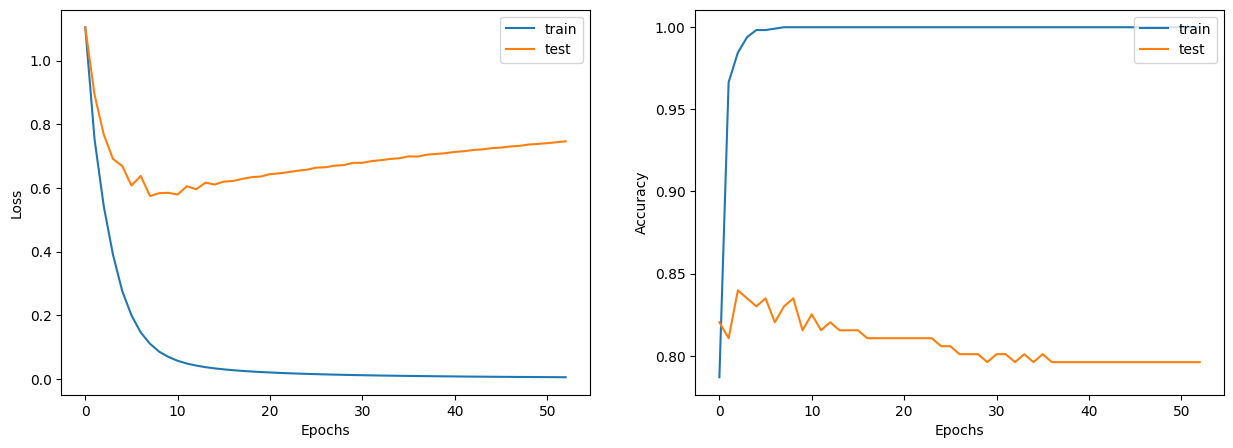

In [78]:
display_learning_curves(history)

In [79]:
# Accuracy en test de GCN

In [80]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model1.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 83.86%


In [81]:
# Entrenamiento de red GSN

In [82]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model2, x_train, y_train)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - acc: 0.1523 - loss: 2.2689 - val_acc: 0.3350 - val_loss: 2.1534
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - acc: 0.3528 - loss: 2.0612 - val_acc: 0.3010 - val_loss: 1.9211
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - acc: 0.4122 - loss: 1.7104 - val_acc: 0.3398 - val_loss: 1.7624
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.4332 - loss: 1.4529 - val_acc: 0.4951 - val_loss: 1.5270
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - acc: 0.5856 - loss: 1.2412 - val_acc: 0.4951 - val_loss: 1.4235
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - acc: 0.6523 - loss: 1.0381 - val_acc: 0.5049 - val_loss: 1.3118
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - acc: 0.6834 - loss: 0.7979 - val_acc: 0.5583 - val_loss: 1.3069
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - acc: 0.8036 - loss: 0.6073 - val_acc: 0.5194 - val_loss: 1.7850
Epoch 9/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 0.7800 - loss:

In [83]:
# Gráficos red GSN

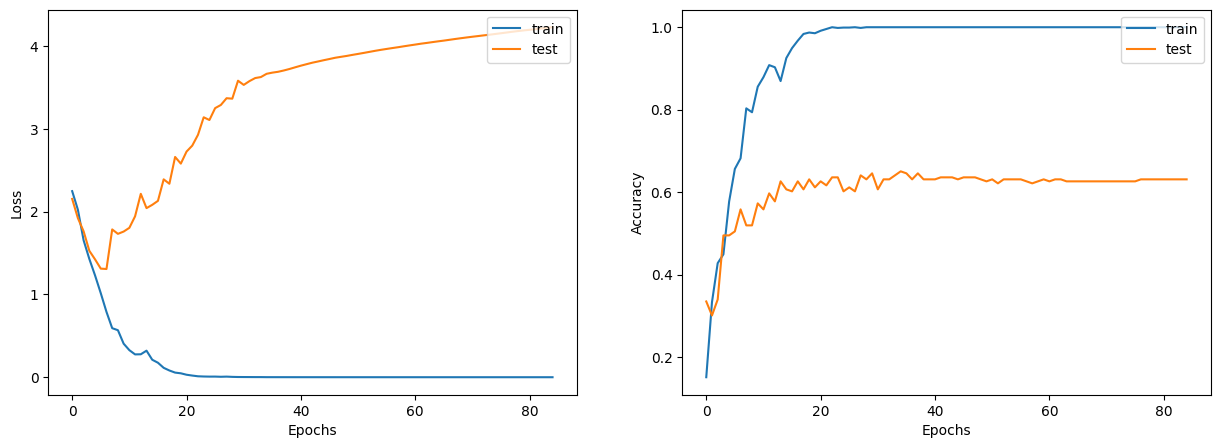

In [84]:
display_learning_curves(history)

In [85]:
# Accuracy en test de GSN

In [86]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model2.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 62.93%


### Preguntas

1. ¿Qué combinación de red obtiene mejor accuracy?
2. Comparando los dos tipos de red, ¿Es significativa la diferencia entre los accuracy?

## 6) [Opcional] Desafío

Crea una red de tipo GNN utilizando cualquier arquitectura de las vistas, es decir, puede elegir libremente la configuración de las FNN, tasa de *dropout*, funciones de agregación y actualización, etc.

También puede utilizar alguna técnica de *data augmentation* de las mencionadas en clases.

Está prohibido utilizar cualquier librería externa que implemente alguna capa de su GNN, solo crea tu propia implementación (tal como se realizó anteriormente).

**El desafío consiste en superar por al menos un punto porcentual el rendimiento obtenido por las redes anteriores**

In [87]:
# Libre